In [4]:
# This module attempts to implement the DQ model of a BLDC motor following the paper here:
# https://ieeexplore.ieee.org/document/6687627

import math
import numpy as np

In [5]:
# Motor Parameters (Table 1)
Rs = 0.982  # Ohms, stator resistance
Ld = 2.9e-3  # Henry, d-axis inductance
Lq = 3.0e-3  # Henry, q-axis inductance
Fl_pm = 75e-3  # Weber, Flux linkage by permanent magnets
Pn = 4  # Number of pole pairs
J = 0.425e-3  # kgm^2, rotor inertia

Integration failed


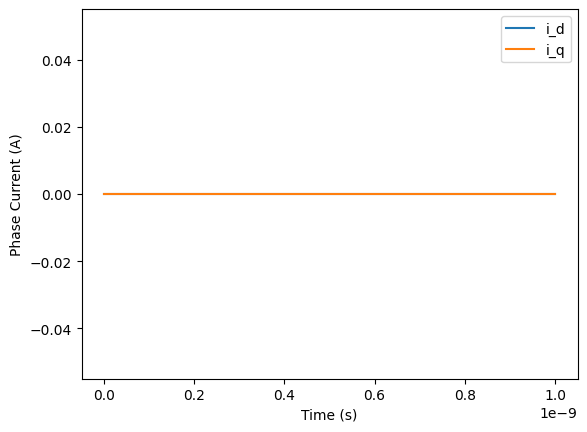

In [12]:
# Experiment with simulating the motor in an open loop fashion

# (NOT WORKING!!)
from scipy.integrate import ode
import matplotlib.pyplot as plt


u_q = 0.0  # Volts, q-axis voltage command input
u_d = 0.0  # Volts, d-axis voltage command input
k = 1.0/3.0
Ts = 1e-9  # seconds, sampling time
sim_time_sec = 0.1 # seconds, simulation time

# Initial conditions
theta = 0.0  # radians, rotor position
omega = 0.0  # radians/second, rotor speed
i_d = 0.0  # Amps, d-axis current
i_q = 0.0  # Amps, q-axis current
fl_d = 0.0  # Weber, d-axis flux linkage
fl_q = 0.0  # Weber, q-axis flux linkage
fl_d_prev = 0.0  # Weber, previous d-axis flux linkage
fl_q_prev = 0.0  # Weber, previous q-axis flux linkage

# Simulation


def state_derivatives(t, state, u_d, u_q):
    # Unpack the state
    i_d, i_q, fl_d, fl_q, omega, theta = state

    # Calculate flux linkage derivatives using equation (16)
    d_fl_d = (u_d - Rs * i_d + omega * fl_q) / Ld
    d_fl_q = (u_q - Rs * i_q - omega * fl_d) / Lq

    # Calculate current derivatives using equation (19)
    d_i_d = (u_d - Rs * i_d - omega * fl_q - d_fl_d) / Ld
    d_i_q = (u_q - Rs * i_q + omega * fl_d - d_fl_q) / Lq

    # Calculate electromagnetic torque using equation (25)
    Tem = (3 * Pn * (fl_d * i_q + fl_q * i_d)) / (2 * k)

    # Calculate speed derivative using equation (27)
    d_omega = (Tem - 0.0) / J  # Assuming no load torque

    # Calculate position derivative
    d_theta = omega

    return np.array([d_i_d, d_i_q, d_fl_d, d_fl_q, d_omega, d_theta])

# Initial conditions
state0 = np.array([i_d, i_q, fl_d, fl_q, omega, theta])

# Create the ODE solver
solver = ode(state_derivatives)
solver.set_integrator('dopri5', atol=1e-8, rtol=1e-6, nsteps=1000)
solver.set_initial_value(state0, 0)
solver.set_f_params(u_d, u_q)

# Integrate the ODEs
t_sol = [0]
state_sol = [state0]
t = 0
while solver.successful() and t < sim_time_sec:
    t += Ts
    solver.integrate(Ts)
    t_sol.append(solver.t)
    state_sol.append(solver.y)

if not solver.successful():
    print('Integration failed')

# Plot the phase currents
phase_currents = np.array(state_sol)[:, :2]
plt.plot(t_sol, phase_currents)
plt.xlabel('Time (s)')
plt.ylabel('Phase Current (A)')
plt.legend(['i_d', 'i_q'])
plt.show()

# phase_currents = np.zeros((3, int(sim_time_sec/Ts)))
# for step in range(int(sim_time_sec/Ts)):

#     if step == 100 and u_q < 1.0:
#         u_q += 0.001

#     # Equation 16: Compute the flux linkages
#     fl_d = Ld * i_d + (3.0 * k * Fl_pm) / 2.0
#     fl_q = Lq * i_q

#     # Equation 19: Solve for new Id/Iq
#     d_fl_d = (fl_d - fl_d_prev) / Ts    # Derivative of d-axis flux linkage
#     d_fl_q = (fl_q - fl_q_prev) / Ts    # Derivative of q-axis flux linkage

#     i_d = (u_d - d_fl_d - omega * fl_q) / Rs
#     i_q = (u_q - d_fl_q + omega * fl_d) / Rs

#     # Equation 25: Solve for electromechanical torque
#     Tem = (2.0 * Pn * (fl_d * i_q + fl_q * i_d)) / (3.0 * k ** 2)

#     # Equation 27: Solve for new omega
#     omega = omega + (Ts / J) * (Tem - 0.0)  # No load torque

#     # Solve for new theta
#     theta = (theta + omega * Ts) % (2.0 * math.pi)  # Rotor position

#     # Update previous values
#     fl_d_prev = fl_d
#     fl_q_prev = fl_q

#     # Convert i_d and i_q to Ia, Ib, Ic
#     Ia = i_d / 2.0
#     Ib = (-i_d + math.sqrt(3) * i_q) / 2.0
#     Ic = (-i_d - math.sqrt(3) * i_q) / 2.0

#     phase_currents[0, step] = Ia
#     phase_currents[1, step] = Ib
#     phase_currents[2, step] = Ic


